In [1]:
import os
import sys
# import math
import random

import gymnasium
sys.modules["gym"] = gymnasium

import gymnasium as gym
from gym.wrappers import RecordVideo

from base64 import b64encode
from IPython.display import HTML

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

print("CUDA доступна:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from tqdm import tqdm

CUDA доступна: True


In [2]:
os.makedirs("./video", exist_ok=True)

def render_mp4(videopath: str) -> str:

    """
    Функция для рендеринга видео в формате mp4.
    Args:
    videopath - Путь к файлу с видео.
    """
    
    mp4 = open(videopath, 'rb').read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return f'<video width=600 controls><source src="data:video/mp4; base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [3]:
env = gym.make("CarRacing-v3", render_mode="rgb_array") # , lap_complete_percent=0.95, domain_randomize=False, continuous=False
env = RecordVideo(env, video_folder="video", name_prefix=f"Racing", episode_trigger=lambda ep: ep % 200 == 0)
state, info = env.reset()
n_observations = len(state)
print(n_observations)

96


c:\Desk\Data\Otus\OtusHomework3\venv\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Desk\Data\Otus\OtusHomework3\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [4]:
class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        # Свёрточные слои остаются без изменений
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(4096, 512)
        # Отдельные выходные головы
        self.steer_mean = nn.Linear(512, 1)         # для рулевого управления
        self.acc_brake_mean = nn.Linear(512, 2)       # для акселератора и тормоза
        # Логарифмы стандартных отклонений
        self.steer_log_std = nn.Parameter(torch.zeros(1))
        self.acc_brake_log_std = nn.Parameter(torch.zeros(2))
        
    def forward(self, x):
        # Прямой проход по свёрточным слоям
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc(x))
        # Отдельно вычисляем параметры для двух групп действий
        steer = torch.tanh(self.steer_mean(x))
        acc_brake = torch.sigmoid(self.acc_brake_mean(x))
        # Объединяем в единый вектор действий: [steering, acceleration, brake]
        mean = torch.cat([steer, acc_brake], dim=-1)
        # Аналогично объединяем log_std для каждой группы
        steer_std = self.steer_log_std.expand_as(steer)
        acc_brake_std = self.acc_brake_log_std.expand_as(acc_brake)
        log_std = torch.cat([steer_std, acc_brake_std], dim=-1)
        return mean, log_std

class CriticNet(nn.Module):
    def __init__(self):
        """
        Сеть Critic для CarRacing-v3.
        Принимает изображение (3,96,96) и выдает скалярное значение ценности (value).
        """
        super(CriticNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(4096, 512)
        self.value = nn.Linear(512, 1)
        
    def forward(self, x):
        # x ожидается в формате [batch_size, 3, 96, 96]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # x = x.view(x.size(0), -1)
        x = x.reshape(x.size(0), -1)  # Используем reshape вместо view
        x = F.relu(self.fc(x))
        value = self.value(x)
        return value

actor_func = ActorNet().to(device)
value_func = CriticNet().to(device)

def pick_sample(s):
    with torch.no_grad():
        # Преобразуем входное состояние s из (96, 96, 3) в (3, 96, 96) и добавляем размер батча
        s_transposed = np.transpose(s, (2, 0, 1))
        s_batch = np.expand_dims(s_transposed, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float, device=device)
        
        # Получаем параметры распределения из сети Actor (предполагается, что actor_func возвращает (mean, log_std))
        mean, log_std = actor_func(s_batch)
        std = torch.exp(log_std)
        
        # Создаем нормальное распределение и сэмплируем действие
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        
        # Убираем размер батча и преобразуем в NumPy-массив
        action_np = action.squeeze(0).cpu().numpy()
        
        # Возвращаем NumPy-массив с типом float64
        return action_np.astype(np.float64)



In [5]:
%time
gamma = 0.99  # дисконтирование
reward_records = []  # массив наград

# Оптимизаторы
opt1 = torch.optim.AdamW(value_func.parameters(), lr=25e-4) 
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=25e-4)

# количество циклов обучения
num_episodes = 2000
# 
for i in tqdm(range(num_episodes)):
    # в начале эпизода обнуляем массивы и сбрасываем среду
    done = False
    states = [] 
    actions = []
    rewards = []
    s, _ = env.reset()
    s = s.astype(np.float32) / 255.0

    # пока не достигнем конечного состояния продолжаем выполнять действия
    while not done:
        # добавить состояние в список состояний
        states.append(s.tolist())
        # по текущей политике получить действие
        a = pick_sample(s)
        # выполнить шаг, получить награду (r), следующее состояние (s) и флаги конечного состояния (term, trunc)
        s, r, term, trunc, _ = env.step(a)
        # если конечное состояние - устанавливаем флаг окончания в True
        done = term or trunc
        # добавляем действие и награду в соответствующие массивы
        actions.append(a)
        rewards.append(r)
    # print(sum(rewards))        

    #
    # Если траектория закончилась (достигли финального состояния)
    #
    # формируем массив полной награды для каждого состояния
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Оптимизируем параметры сетей
    #

    # Оптимизируем value loss (Critic)
    # Обнуляем градиенты в оптимизаторе
    opt1.zero_grad()
    # преобразуем состояния и суммарные награды для каждого состояния в тензор
    states = torch.tensor(states, dtype=torch.float).to(device)
    states = states.permute(0, 3, 1, 2)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)

    # Вычисляем лосс
    values = value_func(states)
    values = values.squeeze(dim=1)
    vf_loss = F.mse_loss(
        values,
        cum_rewards,
        reduction="none")
    # считаем градиенты
    vf_loss.sum().backward()
    # делаем шаг оптимизатора
    opt1.step()

    # Оптимизируем policy loss (Actor)
    with torch.no_grad():
        values = value_func(states)

    # Обнуляем градиенты
    opt2.zero_grad()
    # преобразуем к тензорам
    # actions = torch.tensor(actions, dtype=torch.int64).to(device)
    actions_tensor = torch.tensor(actions, dtype=torch.float, device=device)
    # считаем advantage функцию
    # advantages = cum_rewards - values
    advantages = cum_rewards - values.detach().squeeze(dim=1)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


    # Получаем параметры распределения из сети Actor (распаковываем кортеж)
    mean, log_std = actor_func(states)
    std = torch.exp(log_std)

    # Создаем нормальное распределение по каждому измерению действия
    dist = torch.distributions.Normal(mean, std)
    # Вычисляем log probability для каждого действия.
    # Если действия многомерные, суммируем лог вероятности по последнему измерению.
    log_probs = dist.log_prob(actions_tensor).sum(dim=-1)
    # Определяем loss: умножаем отрицательные log probabilities на advantage
    # pi_loss = -log_probs * advantages

    beta = 0.05  # коэффициент энтропийного бонуса
    entropy = dist.entropy().sum(dim=-1)  # суммируем по действиям
    pi_loss = -log_probs * advantages - beta * entropy


    # Вычисляем градиенты и делаем шаг оптимизатора
    pi_loss.sum().backward()
    opt2.step()


    # # считаем лосс
    # logits, _ = actor_func(states)
    # log_probs = -F.cross_entropy(logits, actions, reduction="none")
    # pi_loss = -log_probs * advantages
    
    # # считаем градиент
    # pi_loss.sum().backward()
    # # делаем шаг оптимизатора
    # opt2.step()

    # Выводим итоговую награду в эпизоде (max 500)    
    reward_records.append(sum(rewards))

    # if i % 100 == 0:
    #     print("Run episode {} with average reward {}".format(i, np.mean(reward_records[-100:])), end="\r")

    # stop if mean reward for 100 episodes > 475.0
    # if np.average(reward_records[-100:]) > 475.0:
    #     break

print("\nDone")
env.close()

CPU times: total: 0 ns
Wall time: 0 ns


  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\deari\AppData\Local\Temp\ipykernel_7464\1027176570.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  actions_tensor = torch.tensor(actions, dtype=torch.float, device=device)
100%|██████████| 2000/2000 [7:40:11<00:00, 13.81s/it]  



Done


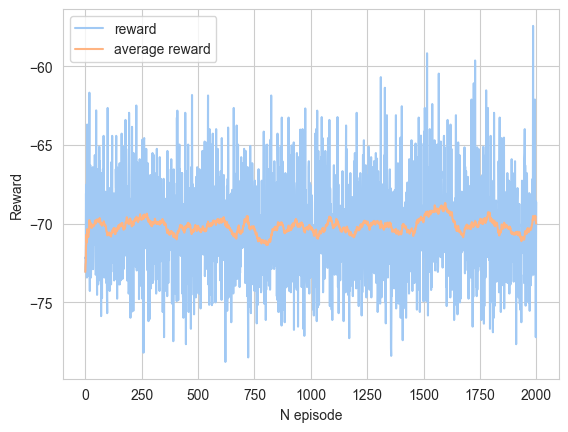

In [6]:
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Plot
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

---
---
---
---

In [7]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0] for i in indices]
        actions  = [self.buffer[i][1] for i in indices]
        rewards  = [self.buffer[i][2] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [self.buffer[i][4] for i in indices]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(buffer_size=20000)

In [8]:
class QNet(nn.Module):
    def __init__(self, hidden_dim=512):
        super(QNet, self).__init__()
        # Свёрточный энкодер для изображения (вход: [3, 96, 96])
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)   # Выход примерно: [32, 23, 23]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)   # Выход примерно: [64, 10, 10]
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)   # Выход примерно: [64, 8, 8]
        # Итоговый размер фич: 64 * 8 * 8 = 4096.
        # После свёрточных слоёв конкатенируем с вектором действия (размер 3)
        self.fc1 = nn.Linear(4096 + 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, s, a):
        # s: [batch, 3, 96, 96], a: [batch, 3]
        x = F.relu(self.conv1(s))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)  # [batch, 4096]
        x = torch.cat([x, a], dim=-1)  # конкатенация с действием
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=512):
        super(PolicyNet, self).__init__()
        # Свёрточный энкодер для изображения
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(4096, hidden_dim)
        # Голова для рулевого управления ([-1, 1])
        self.steer_mean = nn.Linear(hidden_dim, 1)
        # Голова для акселератора и тормоза ([0, 1])
        self.acc_brake_mean = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        # s: [batch, 3, 96, 96]
        x = F.relu(self.conv1(s))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc(x))
        steer = torch.tanh(self.steer_mean(x))
        acc_brake = torch.sigmoid(self.acc_brake_mean(x))
        action = torch.cat([steer, acc_brake], dim=-1)
        return action

In [9]:
#############################
# Создание моделей и оптимизаторов
#############################

# Два критика и их целевые сети
q_origin_model1 = QNet().to(device)  # Q_phi1
q_origin_model2 = QNet().to(device)  # Q_phi2
q_target_model1 = QNet().to(device)  # Q_phi1'
q_target_model2 = QNet().to(device)  # Q_phi2'
_ = q_target_model1.requires_grad_(False)
_ = q_target_model2.requires_grad_(False)

# Актёр и его целевая сеть
mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)    # mu_theta'
_ = mu_target_model.requires_grad_(False)

gamma = 0.99
opt_q1 = torch.optim.AdamW(q_origin_model1.parameters(), lr=0.0005)
opt_q2 = torch.optim.AdamW(q_origin_model2.parameters(), lr=0.0005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)

#############################
# Ornstein-Uhlenbeck шум
#############################

class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=0.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt \
            + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

# Теперь размер шума соответствует размерности действия (3)
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(3), sigma=np.ones(3)*0.1)

def pick_sample(s):
    with torch.no_grad():
        # Преобразуем изображение из формата HWC в CHW
        s = np.transpose(s, (2, 0, 1))
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(0)  # [3]
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        # Гарантируем корректные диапазоны:
        # Для рулевого управления: [-1, 1]
        action[0] = np.clip(action[0], -1.0, 1.0)
        # Для акселератора и тормоза: [0, 1]
        action[1:] = np.clip(action[1:], 0.0, 1.0)
        return action

#############################
# Функция оптимизации
#############################

def optimize(states, actions, rewards, next_states, dones):
    # Преобразуем состояния: список изображений (96,96,3) -> массив [batch, 96,96,3] -> транcпонируем в [batch, 3,96,96]
    states = np.array(states)             # [batch, H, W, C]
    # states = states.permute(0, 3, 1, 2)
    # states = states.transpose(0, 3, 1, 2)   # [batch, 3, H, W]
    states = np.transpose(states, (0, 3, 1, 2))

    # states = states.permute(0, 3, 1, 2)
    states = torch.tensor(states, dtype=torch.float).to(device)

    actions = torch.tensor(actions, dtype=torch.float).to(device)  # [batch, 3]
    rewards = torch.tensor(rewards, dtype=torch.float).unsqueeze(1).to(device)
    
    next_states = np.array(next_states)
    next_states = next_states.transpose(0, 3, 1, 2)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)

    dones = torch.tensor(dones, dtype=torch.float).unsqueeze(1).to(device)

    # Вычисление таргет-значения для критиков (используем минимум из двух целевых оценок)
    with torch.no_grad():
        next_actions = mu_target_model(next_states)
        q1_next = q_target_model1(next_states, next_actions)
        q2_next = q_target_model2(next_states, next_actions)
        q_next = torch.min(q1_next, q2_next)
        q_target = rewards + gamma * (1.0 - dones) * q_next

    # Обновление критика 1
    opt_q1.zero_grad()
    q1_current = q_origin_model1(states, actions)
    loss_q1 = F.mse_loss(q1_current, q_target)
    loss_q1.backward()
    opt_q1.step()

    # Обновление критика 2
    opt_q2.zero_grad()
    q2_current = q_origin_model2(states, actions)
    loss_q2 = F.mse_loss(q2_current, q_target)
    loss_q2.backward()
    opt_q2.step()

    # Обновление актёра: используем q_origin_model1 для вычисления градиента
    opt_mu.zero_grad()
    current_actions = mu_origin_model(states)
    # Отключаем градиенты критика на время расчёта актора
    for p in q_origin_model1.parameters():
        p.requires_grad = False
    actor_loss = -q_origin_model1(states, current_actions).mean()
    actor_loss.backward()
    opt_mu.step()
    for p in q_origin_model1.parameters():
        p.requires_grad = True

In [10]:
#############################
# Обновление целевых сетей
#############################

tau = 0.002
def update_target():
    for param, target_param in zip(q_origin_model1.parameters(), q_target_model1.parameters()):
         target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    for param, target_param in zip(q_origin_model2.parameters(), q_target_model2.parameters()):
         target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    for param, target_param in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
         target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

#############################
# Пример цикла обучения
#############################

# Предполагается, что у вас определён replay buffer с методами add() и sample()
buffer = replayBuffer(buffer_size=20000)
min_buffer_size = 1000
batch_size = 250

num_episodes = 2000
reward_records = []

for episode in tqdm(range(num_episodes)):
    # s = env.reset()   # s – изображение формата (96,96,3)
    s, _ = env.reset()
    s = s.astype(np.float32) / 255.0
    done = False
    cum_reward = 0
    ou_action_noise.reset()  # сброс шума в начале эпизода
    while not done:
        a = pick_sample(s)              # выбираем действие с шумом
        # s_next, r, done, _ = env.step(a)
        s_next, r, terminated, truncated, _ = env.step(a)
        s_next = s_next.astype(np.float32) / 255.0
        done = terminated or truncated
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r

        # Если в буфере достаточно элементов, запускаем оптимизацию
        if buffer.length() >= max(batch_size, min_buffer_size):
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, next_states, dones)
            update_target()

        s = s_next

    reward_records.append(cum_reward)


  2%|▏         | 35/2000 [31:15<29:15:12, 53.59s/it]


KeyboardInterrupt: 

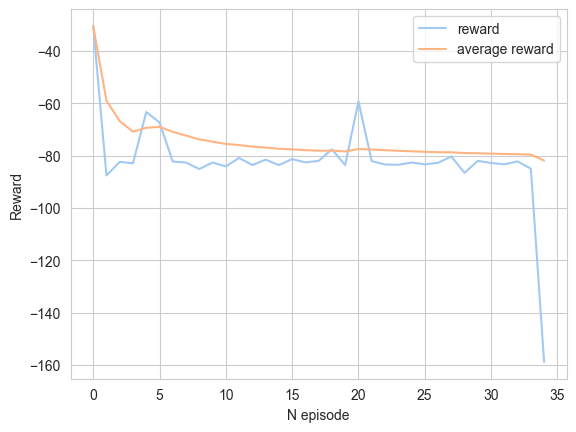

In [11]:
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Plot
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [ ]:
# Сохраняем веса актёра и критиков, а также их оптимизаторы, если нужно
torch.save({
    'mu_origin_model': mu_origin_model.state_dict(),
    'q_origin_model1': q_origin_model1.state_dict(),
    'q_origin_model2': q_origin_model2.state_dict(),
    # Можно сохранить и целевые сети, если требуется:
    'mu_target_model': mu_target_model.state_dict(),
    'q_target_model1': q_target_model1.state_dict(),
    'q_target_model2': q_target_model2.state_dict(),
    # Если требуется – состояния оптимизаторов:
    'opt_mu': opt_mu.state_dict(),
    'opt_q1': opt_q1.state_dict(),
    'opt_q2': opt_q2.state_dict()
}, "agent_checkpoint.pth")